<a href="https://colab.research.google.com/github/AllaAndreevna/Adversarial-attacks-in-ML/blob/main/Create_adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will discuss adversarial attacks on a model.

**Task: to demonstrate the vulnerability of the model to attack**

1) Given a pre-trained image classification model [here](https://github.com/ultralytics/ultralytics/blob/main/docs/en/models/yolov8.md).

2) For this model, we train on the following
dataset [here](http://ufldl.stanford.edu/housenumbers/) or an equivalent.

3) Using the art library, create adversarial examples
that modify the model's prediction and prepare inference
for demonstration.

In [1]:
pip install ultralytics adversarial-robustness-toolbox torch torchvision matplotlib opencv-python scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.1 MB/s eta 0:00:00


Also you need to load dataset via link provided before ([click](http://ufldl.stanford.edu/housenumbers/)). Put files `train_32x32.mat` and `test_32x32.mat` in folder "data".

In [2]:
import matplotlib.pyplot as plt
from ultralytics import YOLO
import scipy.io
import numpy as np
import os
from PIL import Image
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod
import torch.nn as nn
import torch.optim as optim
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
import torch
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Here we are loading the model:

In [3]:
model = YOLO("yolov8n-cls.pt")

In [4]:
model.info()

YOLOv8n-cls summary: 56 layers, 2,719,288 parameters, 0 gradients, 4.4 GFLOPs


(56, 2719288, 0, 4.383948800000001)

Let's check how it predicts the image:

In [5]:
results = model("https://ultralytics.com/images/bus.jpg", show=True)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()




image 1/1 /content/bus.jpg: 224x224 minibus 0.50, police_van 0.29, trolleybus 0.05, golfcart 0.02, jinrikisha 0.02, 4.4ms
Speed: 22.9ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


Load the data:

In [8]:
train_data = scipy.io.loadmat('data/train_32x32.mat')
X_train = np.transpose(train_data['X'], (3, 0, 1, 2)) / 255.0
y_train = train_data['y'].flatten()
y_train[y_train == 10] = 0

test_data = scipy.io.loadmat('data/test_32x32.mat')
X_test = np.transpose(test_data['X'], (3, 0, 1, 2)) / 255.0
y_test = test_data['y'].flatten()
y_test[y_test == 10] = 0


Prepare the data before training:

In [9]:
def prepare_yolo_classification_data(X, y, base_path="dataset"):
    """Подготавливает данные в формате, который ожидает YOLOv8 для классификации"""

    # Создаем структуру папок: dataset/train/class_0, dataset/train/class_1, etc.
    for split in ['train', 'val']:
        for class_id in range(10):  # 10 классов (цифры 0-9)
            os.makedirs(f"{base_path}/{split}/{class_id}", exist_ok=True)

    # Разделяем данные на train/val (80/20)
    n_train = int(0.8 * len(X))

    # Сохраняем training данные
    for i in range(n_train):
        img = (X[i] * 255).astype(np.uint8)
        pil_img = Image.fromarray(img)
        class_folder = f"{base_path}/train/{y[i]}"
        pil_img.save(f"{class_folder}/img_{i}.png")

    # Сохраняем validation данные
    for i in range(n_train, len(X)):
        img = (X[i] * 255).astype(np.uint8)
        pil_img = Image.fromarray(img)
        class_folder = f"{base_path}/val/{y[i]}"
        pil_img.save(f"{class_folder}/img_{i}.png")

    print(f"Данные сохранены в {base_path}/")
    return base_path

# Подготавливаем данные
dataset_path = prepare_yolo_classification_data(X_train, y_train)

Данные сохранены в dataset/


Training:

In [10]:
results = model.train(
    data=dataset_path,
    epochs=10,
    imgsz=32,
    batch=16,
    save=True
)

print("Обучение завершено!")

Ultralytics 8.3.185 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=32, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fal

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 94.6±38.1 MB/s, size: 1.7 KB)


train: Scanning /content/dataset/train... 58605 images, 0 corrupt: 100%|██████████| 58605/58605 [00:06<00:00, 8611.28it/s]


train: New cache created: /content/dataset/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 62.4±24.3 MB/s, size: 1.7 KB)


val: Scanning /content/dataset/val... 14652 images, 0 corrupt: 100%|██████████| 14652/14652 [00:01<00:00, 8199.41it/s]


val: New cache created: /content/dataset/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 32 train, 32 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/10     0.135G      2.326         16         32:   0%|          | 16/3663 [00:01<03:40, 16.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 458/458 [00:07<00:00, 60.92it/s]

                   all      0.707      0.959



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 458/458 [00:07<00:00, 58.99it/s]

                   all      0.776      0.972



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 458/458 [00:07<00:00, 61.08it/s]

                   all      0.812      0.978



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 458/458 [00:07<00:00, 63.91it/s]

                   all      0.839       0.98



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 458/458 [00:07<00:00, 63.85it/s]

                   all      0.851      0.984



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 458/458 [00:08<00:00, 56.53it/s]

                   all      0.866      0.984



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 458/458 [00:07<00:00, 57.27it/s]

                   all      0.872      0.987



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 458/458 [00:08<00:00, 56.39it/s]

                   all      0.876      0.985



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 458/458 [00:07<00:00, 57.55it/s]

                   all      0.883      0.986



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.209G     0.6679         13         32: 100%|██████████| 3663/3663 [02:05<00:00, 29.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 458/458 [00:08<00:00, 57.08it/s]

                   all      0.885      0.986



10 epochs completed in 0.392 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.185 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,447,690 parameters, 0 gradients, 3.3 GFLOPs
train: /content/dataset/train... found 58605 images in 10 classes ✅ 
val: /content/dataset/val... found 14652 images in 10 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 458/458 [00:06<00:00, 71.91it/s]


                   all      0.885      0.986
Speed: 0.0ms preprocess, 0.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
Обучение завершено!


In [11]:
model.val()

Ultralytics 8.3.185 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,447,690 parameters, 0 gradients, 3.3 GFLOPs
train: /content/dataset/train... found 58605 images in 10 classes ✅ 
val: /content/dataset/val... found 14652 images in 10 classes ✅ 
test: None...
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 114.9±49.3 MB/s, size: 1.7 KB)


val: Scanning /content/dataset/val... 14652 images, 0 corrupt: 100%|██████████| 14652/14652 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 916/916 [00:08<00:00, 102.39it/s]


                   all      0.885      0.986
Speed: 0.0ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fdc5a9b1280>
curves: []
curves_results: []
fitness: 0.9357766807079315
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.8852716088294983, 'metrics/accuracy_top5': 0.9862817525863647, 'fitness': 0.9357766807079315}
save_dir: PosixPath('runs/classify/train2')
speed: {'preprocess': 0.013116905200908413, 'inference': 0.3473489198741777, 'loss': 0.0006617648097691047, 'postprocess': 0.0011970161065293066}
task: 'classify'
top1: 0.8852716088294983
top5: 0.9862817525863647


Создаем визуализацию...


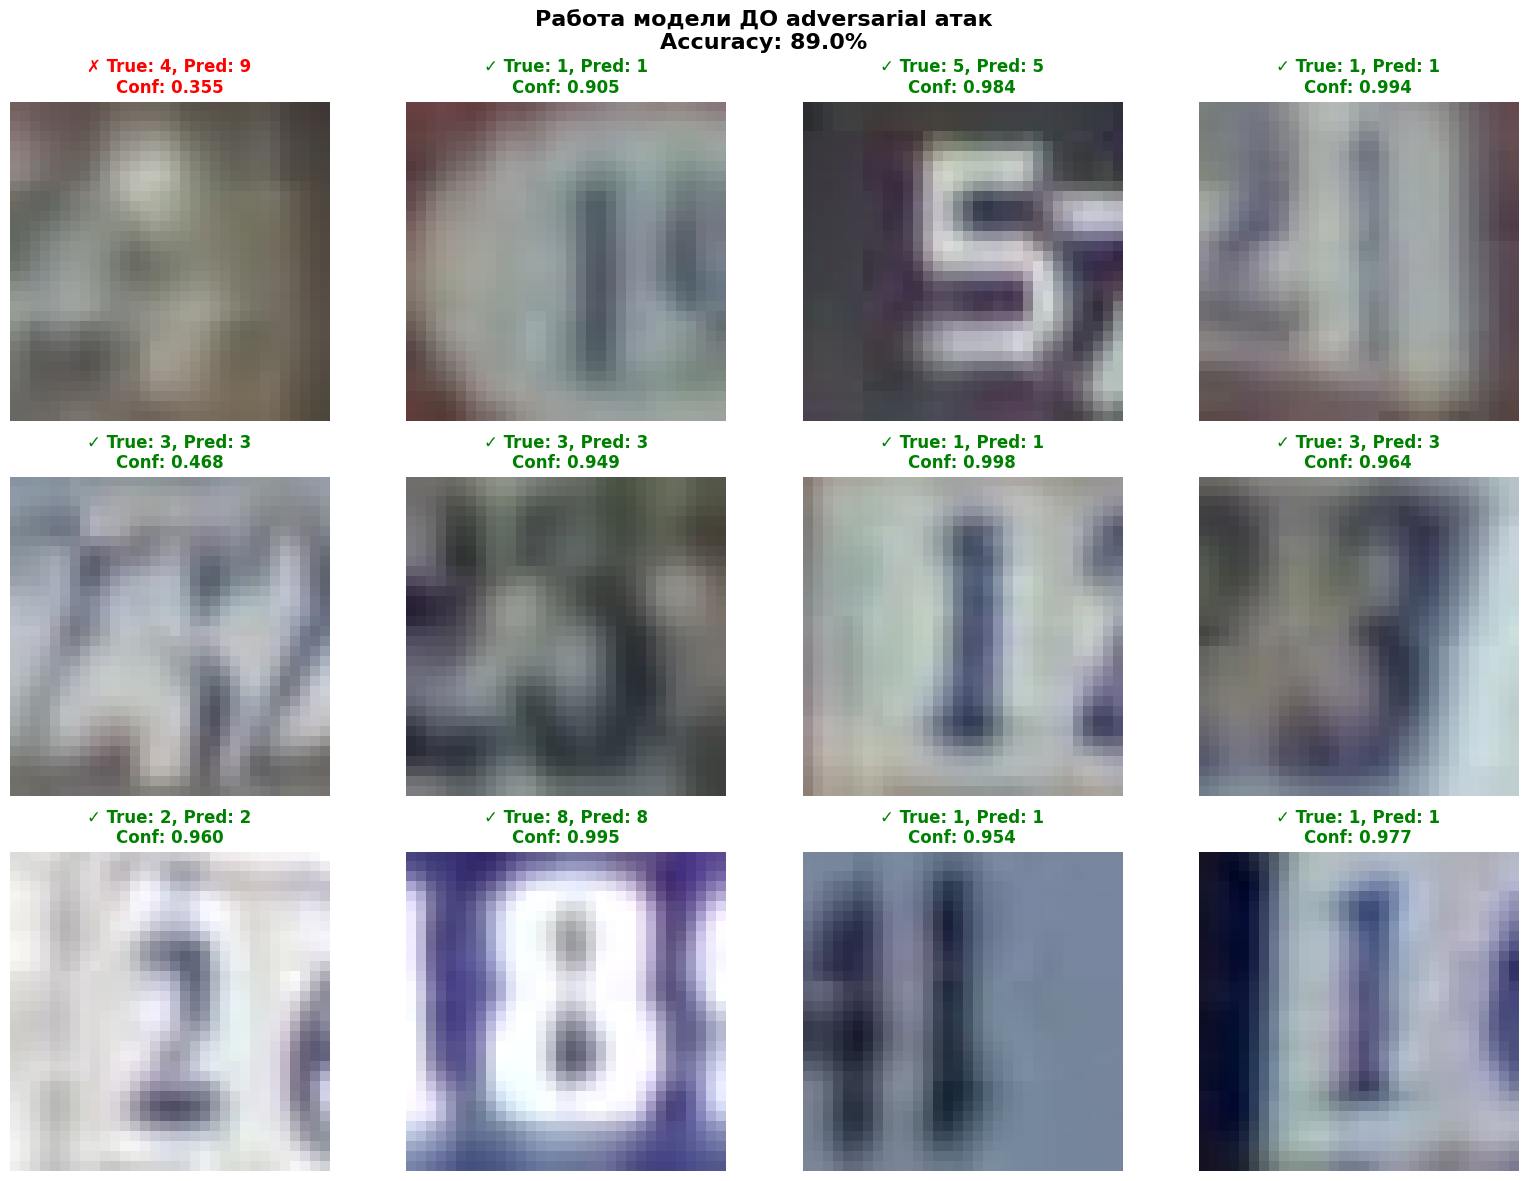

✅ Базовая оценка завершена! Accuracy: 89.00%
Теперь можно переходить к созданию adversarial examples для сравнения.


In [14]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i in range(min(12, len(predictions))):
    idx = test_sample_indices[i]
    img = X_test[idx]
    pred = predictions[i]
    conf = confidences[i]
    true = true_labels_sample[i]

    color = 'green' if pred == true else 'red'
    status = '✓' if pred == true else '✗'

    axes[i].imshow(img)
    axes[i].set_title(f'{status} True: {true}, Pred: {pred}\nConf: {conf:.3f}',
                     color=color, fontweight='bold')
    axes[i].axis('off')

plt.suptitle(f'Работа модели ДО adversarial атак\nAccuracy: {accuracy*100:.1f}%',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('model_before_attacks.png', dpi=150, bbox_inches='tight')
plt.show()

baseline_results = {
    'model': trained_model,
    'accuracy': accuracy,
    'predictions': predictions,
    'confidences': confidences,
    'true_labels': true_labels_sample,
    'test_images': X_test[test_sample_indices],
    'test_indices': test_sample_indices
}

print(f"✅ Базовая оценка завершена! Accuracy: {accuracy*100:.2f}%")
print("Теперь можно переходить к созданию adversarial examples для сравнения.")

Now we move on to creating adversarial examples using the ART library.

 Here, I encountered a problem: it turned out to be impossible to perform a gradient attack (FGSM) on YOLOv8 in a trainable way, because it does not provide logits.

 Therefore, I am implementing two other methods to demonstrate the vulnerability of the model to attacks:

1) Simulating adversarial attacks on YOLO by adding directional noise (without gradients).

2) Demonstration of adversarial attacks by training a ResNet18 (or a simple CNN) on the same SVHN data, bypassing it through art.estimators.classification.PyTorchClassifier, and conducting full-fledged FGSM/PGD attacks with gradients and analysis.

**Method 1**

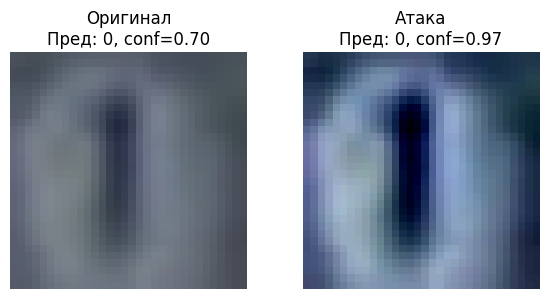

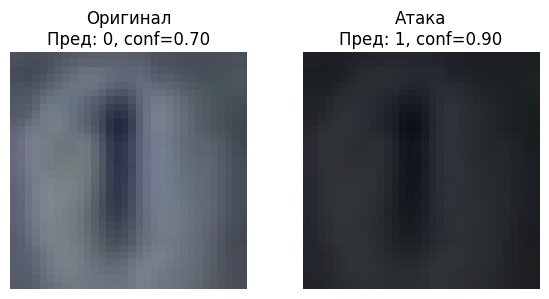

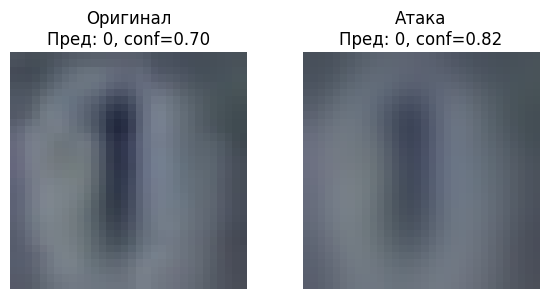

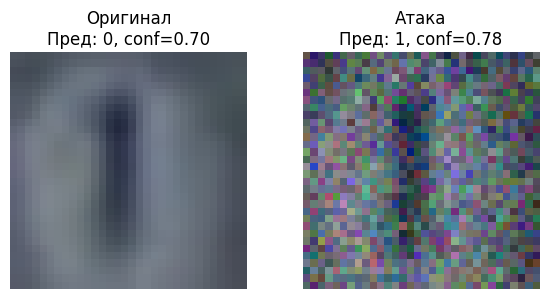

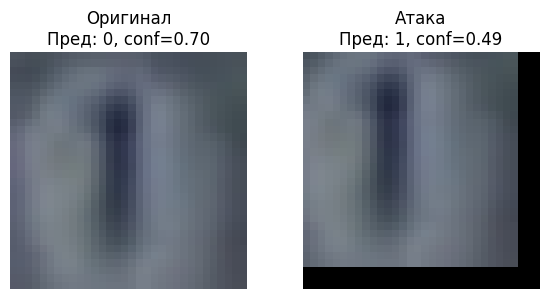

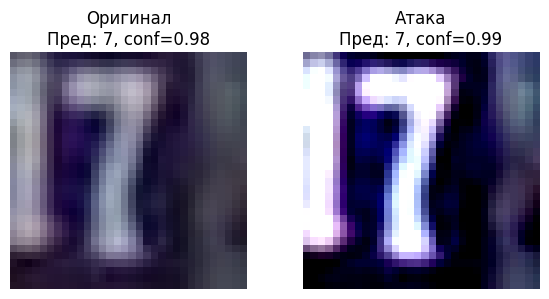

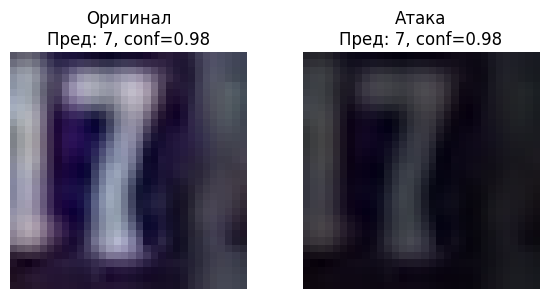

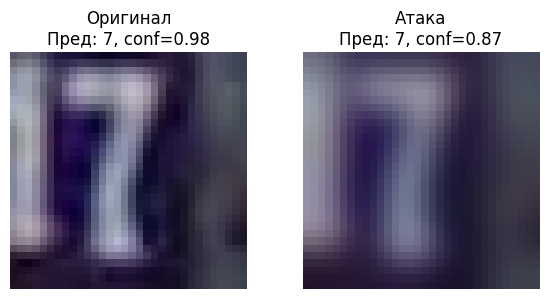

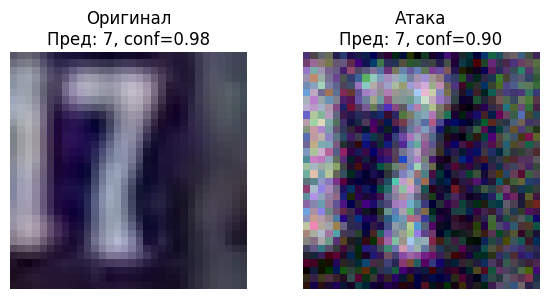

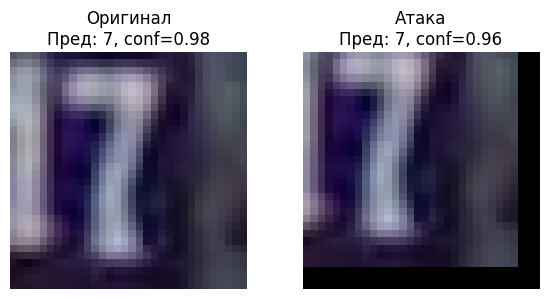

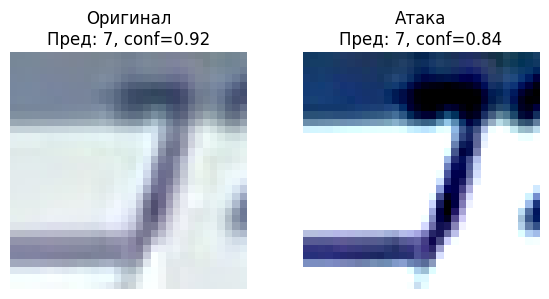

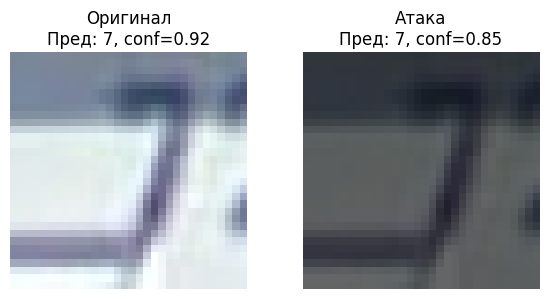

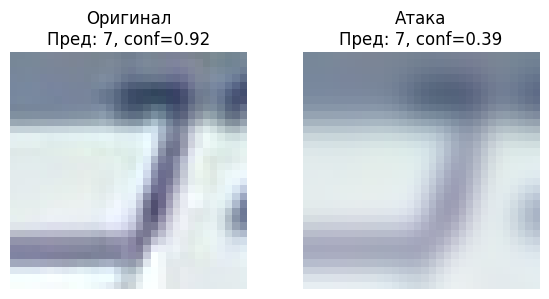

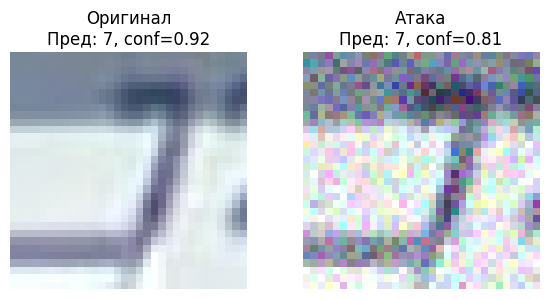

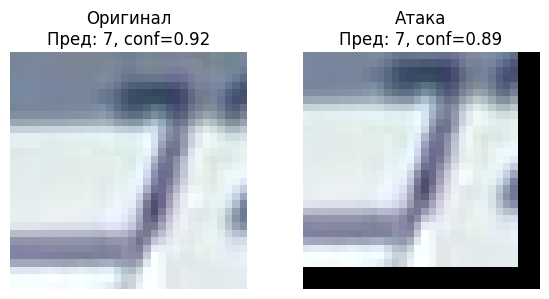

In [15]:
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def yolo_predict(img_pil):
    result = trained_model(img_pil, verbose=False)
    if result[0].probs is not None:
        return result[0].probs.top1, result[0].probs.top1conf.item()
    else:
        return None, None

def show_comparison(original, perturbed, orig_label, pert_label, conf_orig, conf_pert):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(original)
    axes[0].set_title(f"Оригинал\nПред: {orig_label}, conf={conf_orig:.2f}")
    axes[0].axis('off')

    axes[1].imshow(perturbed)
    axes[1].set_title(f"Атака\nПред: {pert_label}, conf={conf_pert:.2f}")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

# Примеры искажений
def apply_attack(img_pil, attack_type):
    if attack_type == "contrast":
        return ImageEnhance.Contrast(img_pil).enhance(2.5)
    elif attack_type == "brightness":
        return ImageEnhance.Brightness(img_pil).enhance(0.4)
    elif attack_type == "blur":
        return img_pil.filter(ImageFilter.GaussianBlur(radius=2))
    elif attack_type == "noise":
        img_np = np.array(img_pil).astype(np.float32) / 255.
        noise = np.random.normal(0, 0.1, img_np.shape)
        noisy_img = np.clip(img_np + noise, 0, 1)
        return Image.fromarray((noisy_img * 255).astype(np.uint8))
    elif attack_type == "shift":
        return img_pil.transform(img_pil.size, Image.AFFINE, (1, 0, 3, 0, 1, 3))
    else:
        return img_pil

# Взять несколько тестовых изображений
attack_types = ["contrast", "brightness", "blur", "noise", "shift"]
indices = [5, 123, 300]

for idx in indices:
    img = X_test[idx]
    true_label = y_test[idx]

    img_pil = Image.fromarray((img * 255).astype(np.uint8))

    # Предсказание на оригинале
    orig_pred, conf_orig = yolo_predict(img_pil)

    # Перебор атак
    for attack in attack_types:
        img_attacked = apply_attack(img_pil, attack)
        pert_pred, conf_pert = yolo_predict(img_attacked)

        show_comparison(img_pil, img_attacked, orig_pred, pert_pred, conf_orig, conf_pert)


Despite the lack of access to gradients, the YOLOv8 classifier is vulnerable to simple visual distortions, such as increased contrast, blurring, shifting, and adding noise. This highlights the need to protect models from even basic attacks without knowledge of their internal architecture.

**Method 2**

Now we will solve the problem in a different way: we will train ResNet18 (not YOLO, as I mentioned above, it didn't work with it) on SVHN, wrap it in ART, and perform real gradient attacks (FGSM and PGD). This will provide a convincing demonstration of the vulnerability of even "strong" models to adversarial attacks.

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
from art.utils import to_categorical
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.models import resnet18
from ultralytics import YOLO

In [17]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = resnet18(weights=None)
print(f"Device: {device}")
print(f"Model on device: {next(model.parameters()).device}")


Device: cuda
Model on device: cpu


In [19]:
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Обучение с tqdm
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    print(f"\nEpoch {epoch + 1}/{epochs}")
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch + 1} complete — Avg loss: {total_loss / len(train_loader):.4f}")


Epoch 1/5


Epoch 1 complete — Avg loss: 0.5970

Epoch 2/5


Epoch 2 complete — Avg loss: 0.2665

Epoch 3/5


Epoch 3 complete — Avg loss: 0.2170

Epoch 4/5


Epoch 4 complete — Avg loss: 0.1805

Epoch 5/5


Epoch 5 complete — Avg loss: 0.1492


Wrapping the model in ART PyTorchClassifier:

In [20]:
classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    clip_values=(0.0, 1.0),
)


Performing FGSM and PGD attacks:

In [21]:
# Подготовим 500 тестовых примеров
X_test = []
y_test = []
for images, labels in test_loader:
    X_test.append(images)
    y_test.append(labels)
    if len(X_test) * 64 >= 500:
        break

X_test = torch.cat(X_test)[:500].numpy()
y_test = torch.cat(y_test)[:500].numpy()
y_test_cat = to_categorical(y_test, 10)

# FGSM атака
fgsm = FastGradientMethod(estimator=classifier, eps=0.05)
X_test_adv_fgsm = fgsm.generate(x=X_test)

# PGD атака
pgd = ProjectedGradientDescent(estimator=classifier, eps=0.1, eps_step=0.01, max_iter=40)
X_test_adv_pgd = pgd.generate(x=X_test)

PGD - Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Let's evaluate the accuracy before and after the attacks:

In [22]:
preds_clean = np.argmax(classifier.predict(X_test), axis=1)
preds_fgsm = np.argmax(classifier.predict(X_test_adv_fgsm), axis=1)
preds_pgd = np.argmax(classifier.predict(X_test_adv_pgd), axis=1)

acc_clean = np.mean(preds_clean == y_test)
acc_fgsm = np.mean(preds_fgsm == y_test)
acc_pgd = np.mean(preds_pgd == y_test)

print(f"Точность на чистых данных: {acc_clean*100:.2f}%")
print(f"Точность после FGSM атаки: {acc_fgsm*100:.2f}%")
print(f"Точность после PGD атаки:  {acc_pgd*100:.2f}%")


Точность на чистых данных: 93.80%
Точность после FGSM атаки: 8.60%
Точность после PGD атаки:  3.20%


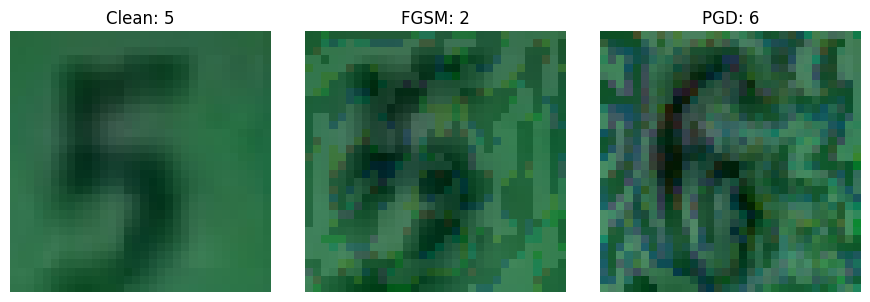

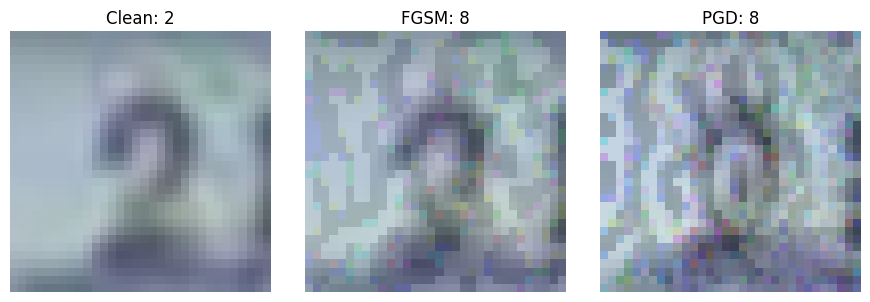

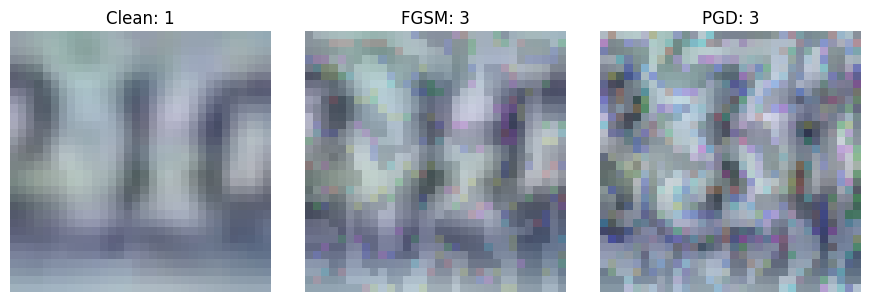

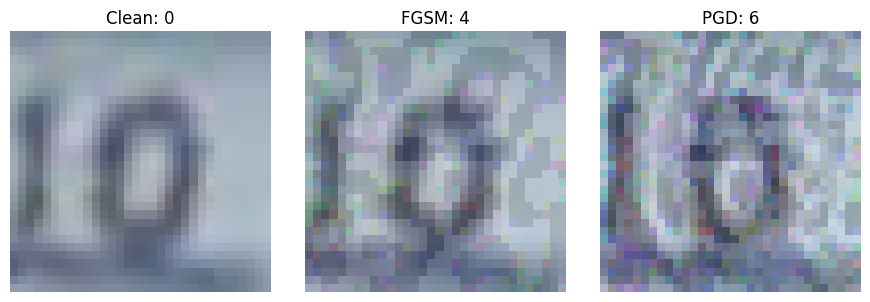

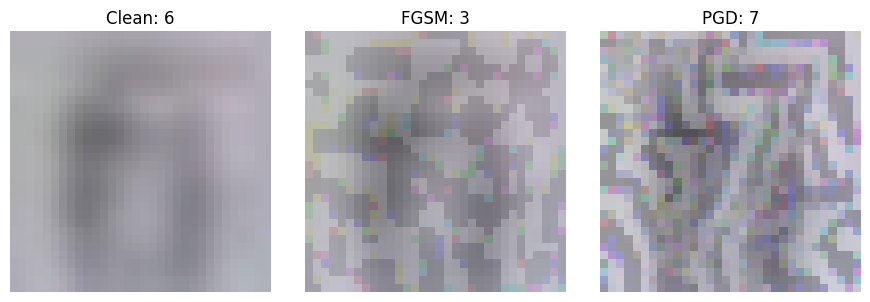

In [23]:
def show_adv_example(i):
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    axs[0].imshow(np.transpose(X_test[i], (1, 2, 0)))
    axs[0].set_title(f"Clean: {preds_clean[i]}")
    axs[1].imshow(np.transpose(X_test_adv_fgsm[i], (1, 2, 0)))
    axs[1].set_title(f"FGSM: {preds_fgsm[i]}")
    axs[2].imshow(np.transpose(X_test_adv_pgd[i], (1, 2, 0)))
    axs[2].set_title(f"PGD: {preds_pgd[i]}")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

for i in [0, 1, 2, 3, 4]:
    show_adv_example(i)


The analysis of classification accuracy before and after the attacks shows that they can indeed make the model extremely vulnerable.

**Method 3**

In fact, it is possible to perform adversarial attacks on the YOLO model if you add the model correctly to PyTorchClassifier (which ART can already work with). This can be done through an adapter that will only return logits from the model, without any other results.

In [37]:
class YoloClsAdapter(torch.nn.Module):
    def __init__(self, core_model):
        super().__init__()
        self.core = core_model

    def forward(self, x):
        out = self.core(x)
        if isinstance(out, (list, tuple)):
            out = out[0]
        return out

We load the model and create a new classifier:

In [38]:
yolo  = YOLO("runs/classify/train/weights/best.pt", task='classify')
adapter = YoloClsAdapter(yolo.model).to(device).eval()

loss = torch.nn.CrossEntropyLoss()

classifier = PyTorchClassifier(
    model=adapter,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    clip_values=(0.0, 1.0)
)

Carry out attacks:

In [39]:
# FGSM атака
fgsm = FastGradientMethod(estimator=classifier, eps=0.05)
X_test_adv_fgsm = fgsm.generate(x=X_test)

# PGD атака
pgd = ProjectedGradientDescent(estimator=classifier, eps=0.1, eps_step=0.01, max_iter=40)
X_test_adv_pgd = pgd.generate(x=X_test)

PGD - Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Let's look at the success rate before and after the attacks:

In [40]:
preds_clean = np.argmax(classifier.predict(X_test), axis=1)
preds_fgsm = np.argmax(classifier.predict(X_test_adv_fgsm), axis=1)
preds_pgd = np.argmax(classifier.predict(X_test_adv_pgd), axis=1)

acc_clean = np.mean(preds_clean == y_test)
acc_fgsm = np.mean(preds_fgsm == y_test)
acc_pgd = np.mean(preds_pgd == y_test)

print(f"Точность на чистых данных: {acc_clean*100:.2f}%")
print(f"Точность после FGSM атаки: {acc_fgsm*100:.2f}%")
print(f"Точность после PGD атаки:  {acc_pgd*100:.2f}%")

Точность на чистых данных: 88.20%
Точность после FGSM атаки: 6.40%
Точность после PGD атаки:  6.40%


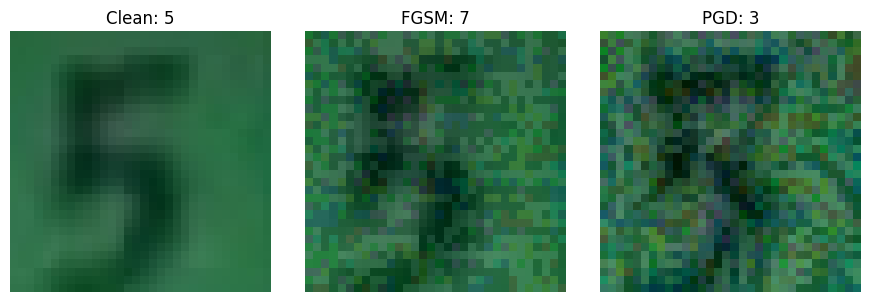

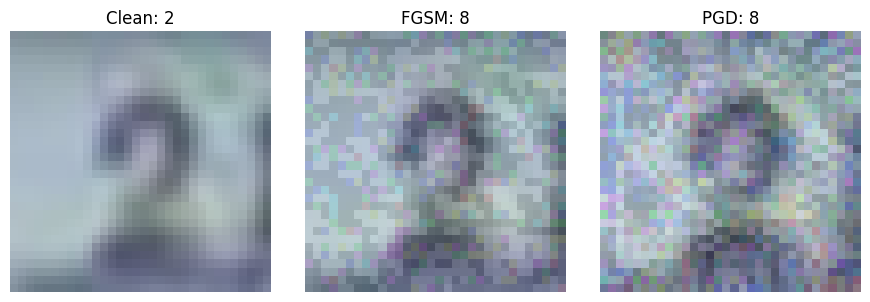

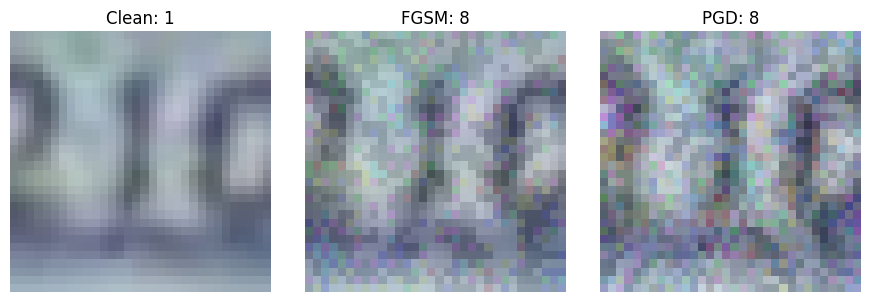

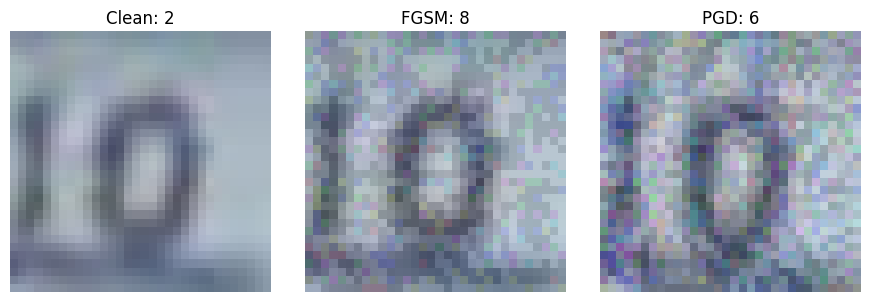

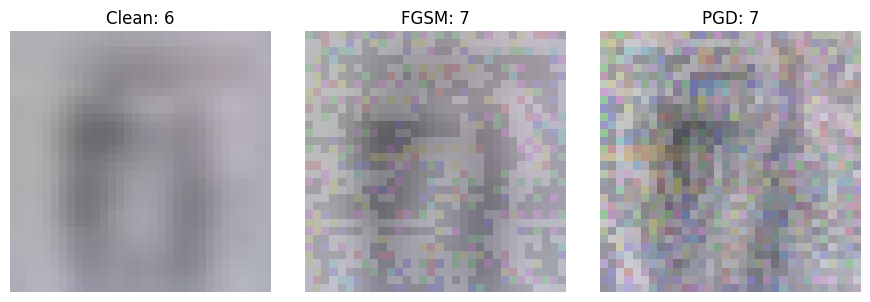

In [41]:
def show_adv_example(i):
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    axs[0].imshow(np.transpose(X_test[i], (1, 2, 0)))
    axs[0].set_title(f"Clean: {preds_clean[i]}")
    axs[1].imshow(np.transpose(X_test_adv_fgsm[i], (1, 2, 0)))
    axs[1].set_title(f"FGSM: {preds_fgsm[i]}")
    axs[2].imshow(np.transpose(X_test_adv_pgd[i], (1, 2, 0)))
    axs[2].set_title(f"PGD: {preds_pgd[i]}")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

for i in [0, 1, 2, 3, 4]:
    show_adv_example(i)


Conclusion: different adversarial examples were created and used to attack the YOLO and ResNet18 models.

During this work, a YOLO model with an accuracy of 88% was trained, which was then attacked with a success rate of 6.4%.